# Speech Emotion Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
import librosa
import librosa.display
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

# DataSet

We will be using **RAVDESS** dataset from kaggle https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en

Here is the filename identifiers as per the official RAVDESS website:

> - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
>  Vocal channel (01 = speech, 02 = song).
> - Emotion 
    - 01 = neutral
    - **02 = calm**
    - **03 = happy**
    - **04 = sad**
    - **05 = angry**
    - **06 = fearful**
    - 07 = disgust
    - 08 = surprised
> - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
> - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
> - Repetition (01 = 1st repetition, 02 = 2nd repetition).
> - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. `02-01-06-01-02-01-12.wav` This means the meta data for the audio file is:

> - Video-only (02)
> - Speech (01)
> - Fearful (06)
> - Normal intensity (01)
> - Statement "dogs" (02)
> - 1st Repetition (01)
> - 12th Actor (12) - Female (as the actor ID number is even)

In [5]:
import os

In [6]:
labels = os.listdir("Data/")

In [7]:
# Removing the emotions which are not necessary for us to predict

# for label in labels:
#     emotion = label.split("-")[2]
    
#     if emotion == "01" or emotion == "08" or emotion == "07":
#         os.remove(f"Data/{label}")

In [8]:
labels[1]

'03-01-02-01-01-01-02.wav'

In [9]:
data, sampling_rate = librosa.load(f"Data/{labels[1]}")

Populating the interactive namespace from numpy and matplotlib


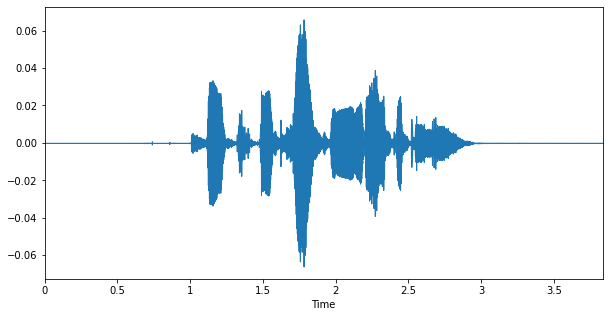

In [10]:
%pylab inline

plt.figure(figsize=(10,5))
librosa.display.waveplot(data, sr=sampling_rate);

In [11]:
# filename
labels[0]

'03-01-02-01-01-01-01.wav'

In [12]:
# Extracting the feelings
labels[0].split("-")[2]

'02'

Now we need to make an array of feeling which will act as labels which we will predict

## Emotion 
- 02 = calm
- 03 = happy
- 04 = sad
- 05 = angry
- 06 = fearful

In [13]:
emotions = [label.split("-")[2] for label in labels]

In [14]:
emotions[:5]

['02', '02', '02', '02', '02']

In [15]:
pd.DataFrame(emotions, columns=["Emotions"]).value_counts().sort_index()

Emotions
02          192
03          192
04          192
05          192
06          192
dtype: int64

## Extracting features

In [16]:
%%time
df_features = pd.DataFrame(columns=["features"])
indx = 0
for filename in labels:
    
    X, sample_rate = librosa.load(f"Data/{filename}", duration=2.5, res_type='kaiser_fast')
    # Convert sample_rate to numpy arra
    sample_rate = np.array(sample_rate)
    
    mfccs_feature = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    feature = np.mean(mfccs_feature.T, axis=0)
    
    df_features.loc[indx] = [feature]
    indx += 1

Wall time: 27 s


In [17]:
df_features.head(5)

,features
0,"[-678.94885, 76.40213, -3.9693217, 24.48506, 2..."
1,"[-629.50836, 54.85913, -15.076416, 19.398994, ..."
2,"[-610.4715, 60.676125, -6.567759, 22.445854, -..."
3,"[-632.85834, 57.813908, -15.912763, 11.7422, -..."
4,"[-705.80634, 72.26668, 5.6474605, 31.054544, 2..."


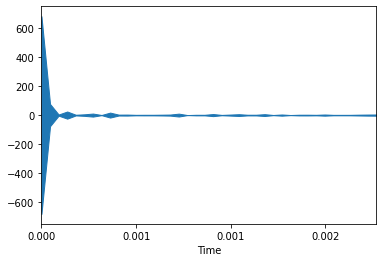

In [18]:
librosa.display.waveplot(df_features['features'][0])

In [19]:
# Create data frame of emotions
df_emotions = pd.DataFrame(emotions, columns=["emotions"])
df_emotions.head()

,emotions
0,02
1,02
2,02
3,02
4,02


In [20]:
df_feature_seperated = pd.DataFrame(df_features["features"].values.tolist())
df_feature_seperated.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-678.948853,76.402130,-3.969322,24.485060,2.343696,5.315933,-10.401676,-0.682352,-17.013817,-3.063685,...,-2.363485,-2.531532,-1.793462,-4.022706,-1.577954,-1.587781,-1.696130,-2.855098,-3.651742,-4.129297
1,-629.508362,54.859131,-15.076416,19.398994,-13.276542,-0.163535,-8.997267,-4.458826,-9.508459,0.139021,...,5.524229,3.406778,3.029715,3.747022,2.242086,2.204940,-1.960129,-1.560523,-0.784178,-1.295257
2,-610.471497,60.676125,-6.567759,22.445854,-2.144975,2.539741,-20.668135,0.123320,-7.860404,-4.285071,...,-1.345382,-2.634505,-2.230956,-0.879381,-1.582407,-1.810162,-3.177479,-5.062142,-3.402217,-2.151505
3,-632.858337,57.813908,-15.912763,11.742200,-23.516590,-6.842883,-16.082939,-12.801092,-19.576881,-5.197330,...,1.959056,4.385456,3.423734,3.627139,4.857632,3.788988,4.757162,2.261868,4.300991,-0.573448
4,-705.806335,72.266678,5.647460,31.054544,2.051290,8.605760,-6.789633,4.041437,-0.349702,2.563606,...,1.105547,-0.419525,1.316671,0.032284,2.234987,-0.531794,-0.942795,-2.564018,-1.889065,0.181104


In [21]:
df = df_feature_seperated
df['emotions'] = df_emotions

In [22]:
df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotions
0,-678.948853,76.402130,-3.969322,24.485060,2.343696,5.315933,-10.401676,-0.682352,-17.013817,-3.063685,...,-2.531532,-1.793462,-4.022706,-1.577954,-1.587781,-1.696130,-2.855098,-3.651742,-4.129297,02
1,-629.508362,54.859131,-15.076416,19.398994,-13.276542,-0.163535,-8.997267,-4.458826,-9.508459,0.139021,...,3.406778,3.029715,3.747022,2.242086,2.204940,-1.960129,-1.560523,-0.784178,-1.295257,02
2,-610.471497,60.676125,-6.567759,22.445854,-2.144975,2.539741,-20.668135,0.123320,-7.860404,-4.285071,...,-2.634505,-2.230956,-0.879381,-1.582407,-1.810162,-3.177479,-5.062142,-3.402217,-2.151505,02
3,-632.858337,57.813908,-15.912763,11.742200,-23.516590,-6.842883,-16.082939,-12.801092,-19.576881,-5.197330,...,4.385456,3.423734,3.627139,4.857632,3.788988,4.757162,2.261868,4.300991,-0.573448,02
4,-705.806335,72.266678,5.647460,31.054544,2.051290,8.605760,-6.789633,4.041437,-0.349702,2.563606,...,-0.419525,1.316671,0.032284,2.234987,-0.531794,-0.942795,-2.564018,-1.889065,0.181104,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,-317.976044,9.312303,-30.541822,-4.778104,-18.936699,-14.217579,-18.650785,-14.171691,-10.407811,10.279816,...,2.892483,1.698947,-1.698887,0.819549,-0.470242,1.039551,0.566789,0.088243,0.920238,06
956,-466.040771,64.058754,-13.208256,18.619799,3.502764,-7.521268,-9.932314,0.287276,-22.124292,-2.246963,...,-1.615298,-3.514129,-4.579769,-3.055513,-2.368344,-1.694364,-3.636990,-2.837501,-3.361457,06
957,-430.179443,21.672758,-33.558323,5.069038,-16.001268,-11.331733,-29.737926,-9.774052,-25.168562,-0.697188,...,-4.243735,-3.616647,0.523052,0.894520,0.068520,1.921872,1.767919,-1.334365,-2.724165,06
958,-476.770508,57.986698,-17.799206,9.529842,-4.249583,-2.204914,-16.382473,-5.649986,-21.760571,-3.960779,...,-1.068851,-1.858995,2.113119,3.029879,4.529030,5.874677,5.346369,4.791262,4.764572,06


In [25]:
# Export the extracted features and emotions to csv file

# df.to_csv("Audio_Data.csv", index=False)

In [3]:
# Re-import the data
df = pd.read_csv("Audio_Data.csv")

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotions
0,-678.94885,76.402130,-3.969322,24.485060,2.343696,5.315933,-10.401676,-0.682352,-17.013817,-3.063685,...,-2.531532,-1.793462,-4.022706,-1.577954,-1.587781,-1.696130,-2.855098,-3.651741,-4.129297,2
1,-629.50836,54.859130,-15.076416,19.398994,-13.276542,-0.163535,-8.997267,-4.458826,-9.508459,0.139020,...,3.406778,3.029715,3.747022,2.242086,2.204940,-1.960129,-1.560523,-0.784178,-1.295257,2
2,-610.47150,60.676125,-6.567759,22.445854,-2.144975,2.539741,-20.668135,0.123320,-7.860404,-4.285071,...,-2.634505,-2.230956,-0.879381,-1.582407,-1.810162,-3.177479,-5.062142,-3.402217,-2.151505,2
3,-632.85834,57.813908,-15.912763,11.742200,-23.516590,-6.842883,-16.082940,-12.801092,-19.576881,-5.197330,...,4.385456,3.423734,3.627139,4.857632,3.788988,4.757162,2.261868,4.300991,-0.573448,2
4,-705.80634,72.266680,5.647461,31.054544,2.051290,8.605760,-6.789633,4.041437,-0.349702,2.563606,...,-0.419525,1.316671,0.032284,2.234987,-0.531794,-0.942795,-2.564018,-1.889065,0.181104,2


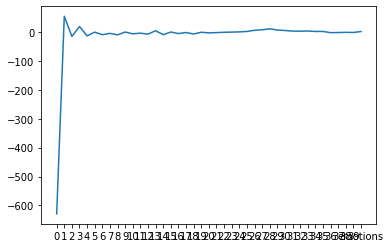

In [5]:
plt.plot(df.loc[1])

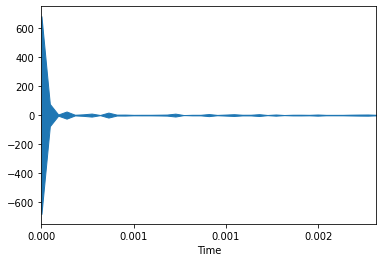

In [7]:
librosa.display.waveplot(np.array(df.loc[0]));

## Create Test and Train Set

In [8]:
X = df.drop("emotions", axis=1)
y = df["emotions"]

In [9]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-678.94885,76.402130,-3.969322,24.485060,2.343696,5.315933,-10.401676,-0.682352,-17.013817,-3.063685,...,-2.363485,-2.531532,-1.793462,-4.022706,-1.577954,-1.587781,-1.696130,-2.855098,-3.651741,-4.129297
1,-629.50836,54.859130,-15.076416,19.398994,-13.276542,-0.163535,-8.997267,-4.458826,-9.508459,0.139020,...,5.524229,3.406778,3.029715,3.747022,2.242086,2.204940,-1.960129,-1.560523,-0.784178,-1.295257
2,-610.47150,60.676125,-6.567759,22.445854,-2.144975,2.539741,-20.668135,0.123320,-7.860404,-4.285071,...,-1.345382,-2.634505,-2.230956,-0.879381,-1.582407,-1.810162,-3.177479,-5.062142,-3.402217,-2.151505
3,-632.85834,57.813908,-15.912763,11.742200,-23.516590,-6.842883,-16.082940,-12.801092,-19.576881,-5.197330,...,1.959056,4.385456,3.423734,3.627139,4.857632,3.788988,4.757162,2.261868,4.300991,-0.573448
4,-705.80634,72.266680,5.647461,31.054544,2.051290,8.605760,-6.789633,4.041437,-0.349702,2.563606,...,1.105547,-0.419525,1.316671,0.032284,2.234987,-0.531794,-0.942795,-2.564018,-1.889065,0.181104


In [10]:
y.head()

0    2
1    2
2    2
3    2
4    2
Name: emotions, dtype: int64

In [11]:
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-678.94885,76.402130,-3.969322,24.485060,2.343696,5.315933,-10.401676,-0.682352,-17.013817,-3.063685,...,-2.363485,-2.531532,-1.793462,-4.022706,-1.577954,-1.587781,-1.696130,-2.855098,-3.651741,-4.129297
1,-629.50836,54.859130,-15.076416,19.398994,-13.276542,-0.163535,-8.997267,-4.458826,-9.508459,0.139020,...,5.524229,3.406778,3.029715,3.747022,2.242086,2.204940,-1.960129,-1.560523,-0.784178,-1.295257
2,-610.47150,60.676125,-6.567759,22.445854,-2.144975,2.539741,-20.668135,0.123320,-7.860404,-4.285071,...,-1.345382,-2.634505,-2.230956,-0.879381,-1.582407,-1.810162,-3.177479,-5.062142,-3.402217,-2.151505
3,-632.85834,57.813908,-15.912763,11.742200,-23.516590,-6.842883,-16.082940,-12.801092,-19.576881,-5.197330,...,1.959056,4.385456,3.423734,3.627139,4.857632,3.788988,4.757162,2.261868,4.300991,-0.573448
4,-705.80634,72.266680,5.647461,31.054544,2.051290,8.605760,-6.789633,4.041437,-0.349702,2.563606,...,1.105547,-0.419525,1.316671,0.032284,2.234987,-0.531794,-0.942795,-2.564018,-1.889065,0.181104


In [13]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [14]:
y.shape

(960, 5)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((768, 40), (192, 40), (768, 5), (192, 5))

In [17]:
y_train.shape

(768, 5)

In [18]:
# input shape
X.loc[1].shape

(40,)

In [19]:
### No of classes
num_labels=y.shape[1]

In [20]:
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           1536      
                                                                 
 activation (Activation)     (None, 40, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           163968    
                                                                 
 activation_1 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                        

In [22]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")

In [25]:
np.random.seed(40)
checkpointer = ModelCheckpoint(filepath='./saveModel/audio_classification.hdf5', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

Epoch 1/100
21/24 [=========================>....] - ETA: 0s - loss: 0.0103 - accuracy: 0.9926
Epoch 00001: val_loss improved from inf to 2.14599, saving model to ./saveModel\audio_classification.hdf5
24/24 [==============================] - 1s 26ms/step - loss: 0.0099 - accuracy: 0.9935 - val_loss: 2.1460 - val_accuracy: 0.6615
Epoch 2/100
21/24 [=========================>....] - ETA: 0s - loss: 0.0166 - accuracy: 0.9911
Epoch 00002: val_loss did not improve from 2.14599
24/24 [==============================] - 0s 17ms/step - loss: 0.0154 - accuracy: 0.9922 - val_loss: 2.1675 - val_accuracy: 0.6562
Epoch 3/100
21/24 [=========================>....] - ETA: 0s - loss: 0.0123 - accuracy: 0.9955
Epoch 00003: val_loss did not improve from 2.14599
24/24 [==============================] - 0s 17ms/step - loss: 0.0108 - accuracy: 0.9961 - val_loss: 2.3484 - val_accuracy: 0.6510
Epoch 4/100
23/24 [===========================>..] - ETA: 0s - loss: 0.0092 - accuracy: 0.9973
Epoch 00004: val_loss 

23/24 [===========================>..] - ETA: 0s - loss: 0.1450 - accuracy: 0.9552
Epoch 00030: val_loss did not improve from 2.08111
24/24 [==============================] - 1s 24ms/step - loss: 0.1412 - accuracy: 0.9557 - val_loss: 2.2646 - val_accuracy: 0.6146
Epoch 31/100
21/24 [=========================>....] - ETA: 0s - loss: 0.0749 - accuracy: 0.9717
Epoch 00031: val_loss improved from 2.08111 to 1.98515, saving model to ./saveModel\audio_classification.hdf5
24/24 [==============================] - 1s 53ms/step - loss: 0.0686 - accuracy: 0.9753 - val_loss: 1.9851 - val_accuracy: 0.6615
Epoch 32/100
22/24 [==========================>...] - ETA: 0s - loss: 0.0450 - accuracy: 0.9872
Epoch 00032: val_loss did not improve from 1.98515
24/24 [==============================] - 1s 24ms/step - loss: 0.0513 - accuracy: 0.9857 - val_loss: 2.4487 - val_accuracy: 0.6302
Epoch 33/100
21/24 [=========================>....] - ETA: 0s - loss: 0.0322 - accuracy: 0.9881
Epoch 00033: val_loss did n

Epoch 59/100
24/24 [==============================] - ETA: 0s - loss: 3.6212e-04 - accuracy: 1.0000
Epoch 00059: val_loss did not improve from 1.88908
24/24 [==============================] - 1s 45ms/step - loss: 3.6212e-04 - accuracy: 1.0000 - val_loss: 2.0738 - val_accuracy: 0.6979
Epoch 60/100
21/24 [=========================>....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000  
Epoch 00060: val_loss did not improve from 1.88908
24/24 [==============================] - 1s 30ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.0343 - val_accuracy: 0.7135
Epoch 61/100
24/24 [==============================] - ETA: 0s - loss: 2.2362e-04 - accuracy: 1.0000
Epoch 00061: val_loss did not improve from 1.88908
24/24 [==============================] - 0s 17ms/step - loss: 2.2362e-04 - accuracy: 1.0000 - val_loss: 2.0728 - val_accuracy: 0.7188
Epoch 62/100
23/24 [===========================>..] - ETA: 0s - loss: 8.5802e-04 - accuracy: 1.0000
Epoch 00062: val_loss did not improve from 1.88908


Epoch 89/100
23/24 [===========================>..] - ETA: 0s - loss: 0.0089 - accuracy: 0.9973
Epoch 00089: val_loss did not improve from 1.88908
24/24 [==============================] - 1s 25ms/step - loss: 0.0098 - accuracy: 0.9961 - val_loss: 2.1013 - val_accuracy: 0.6875
Epoch 90/100
22/24 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000
Epoch 00090: val_loss did not improve from 1.88908
24/24 [==============================] - 1s 23ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.0520 - val_accuracy: 0.6615
Epoch 91/100
22/24 [==========================>...] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 00091: val_loss did not improve from 1.88908
24/24 [==============================] - 0s 19ms/step - loss: 0.0119 - accuracy: 0.9987 - val_loss: 2.0327 - val_accuracy: 0.6875
Epoch 92/100
23/24 [===========================>..] - ETA: 0s - loss: 0.0138 - accuracy: 0.9946
Epoch 00092: val_loss did not improve from 1.88908
24/24 [===============

In [29]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.6510416865348816